In [19]:
import numpy as np
import tensorflow as tf

val_data = np.load("rossler_val.npy")  # Shape: (num_val, train_steps, 3)
train_data = np.load("rossler_train.npy")  # Shape: (num_train, train_steps, 3)
test_data = np.load("rossler_test.npy")  # Shape: (num_test, test_steps, 3)

In [20]:
print("Validation data shape:",val_data.shape)
print("Train data shape:",train_data.shape)
print("Test data shape:",test_data.shape)

Validation data shape: (200, 256, 3)
Train data shape: (800, 256, 3)
Test data shape: (200, 1024, 3)


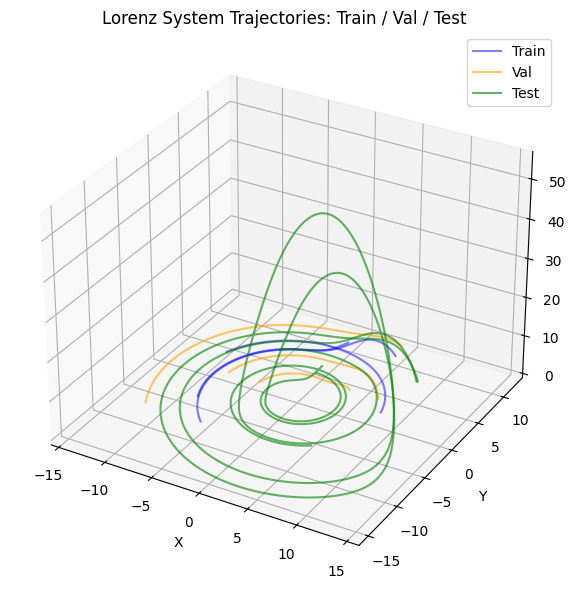

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def plot_lorenz_trajectories(train_data, val_data, test_data, num_samples=3):
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot train trajectories
    for i in range(min(num_samples, len(train_data))):
        traj = train_data[i]
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='blue', alpha=0.5, label='Train' if i == 0 else "")

    # Plot val trajectories
    for i in range(min(num_samples, len(val_data))):
        traj = val_data[i]
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='orange', alpha=0.6, label='Val' if i == 0 else "")

    # Plot test trajectories
    for i in range(min(num_samples, len(test_data))):
        traj = test_data[i]
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='green', alpha=0.6, label='Test' if i == 0 else "")

    ax.set_title("Lorenz System Trajectories: Train / Val / Test")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Usage
plot_lorenz_trajectories(train_data, val_data, test_data, num_samples=3)


In [22]:
batch_size = 256
trajLength = 256 #length of each trajectory in the dataset
numTraj = 2048 #total number of trajectories in the dataset
numTraj_val = 64
input_dim = 3
S=255
num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

In [23]:
print(num_batches_train)
print(num_batches_val)

2048
64


In [24]:
min_val = tf.reduce_min(val_data)
max_val = tf.reduce_max(val_data)

min_train = tf.reduce_min(train_data)
max_train = tf.reduce_max(train_data)

min_test = tf.reduce_min(test_data)
max_test = tf.reduce_max(test_data)

train_data = (train_data - min_train) / (max_train - min_train)
validation_data = (val_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
train_data = tf.reshape(train_data, (-1,3))
validation_data = tf.cast(validation_data, tf.float32)
validation_data = tf.reshape(validation_data, (-1,3))
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(test_data, tf.float32)

In [25]:
train_data

<tf.Tensor: shape=(204800, 3), dtype=float32, numpy=
array([[0.7459073 , 0.55693036, 0.5139131 ],
       [0.7453746 , 0.5593981 , 0.5140724 ],
       [0.7448156 , 0.56186545, 0.51423454],
       ...,
       [0.1607404 , 0.3037768 , 0.509885  ],
       [0.16282247, 0.29986838, 0.5098862 ],
       [0.16494368, 0.2959732 , 0.50988734]], dtype=float32)>

In [26]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout

In [27]:
class EncoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(500, activation="relu")
        self.dense2 = Dense(32, activation="tanh") 
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(0.1) 

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.layer_norm(x)  # Apply LayerNormalization after the dense layer
        x = self.dropout(x)
        return x

In [28]:
# Koopman Layer
class KoopmanLayer(keras.layers.Layer):
    def __init__(self, S):
        super(KoopmanLayer, self).__init__()
        self.S = S

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.K = self.add_weight(
            name="Koopman_weight",
            shape=(latent_dim, latent_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, Z):
        len = tf.shape(Z)[0]
        trajLength = len
        latent_dim = tf.shape(Z)[1]
        
        if len>self.S:
            Z1 = Z[0:self.S+1]
            trajLength = self.S
        else:
            Z1 = Z

        z_shift = Z[1:trajLength+1,:]
        z_first = Z[0,:]
        # Compute Z2_tilde using matrix multiplication with K
        Z2_tilde = tf.zeros([trajLength, latent_dim], dtype=tf.float32)
        
        for m in range(trajLength - 1):  # 0 to trajLength-2
            indices = tf.constant([[m]])  # Use `m` directly as index
            if m == 0:
                # First step, apply Koopman operator to z_first
                updates = [tf.linalg.matvec(self.K, z_first)]
            else:
                # Subsequent steps, apply Koopman operator to z_shift
                updates = [tf.linalg.matvec(self.K, z_shift[m, :])]

            # Update Z2_tilde with computed values
            Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)

        return Z, Z2_tilde, z_shift

# Koopman Model
class KoopmanModel(keras.Model):
    def __init__(self, S):
        super(KoopmanModel, self).__init__()
        self.koopman = KoopmanLayer(S)

    def call(self, z):
        z, Z2_tilde, z_shift = self.koopman(z) 
        
        #z: Latent variables of x in the lifted space
        #z2_tilde: Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
        return z,Z2_tilde,z_shift  # Pass only transformed output to the decoder

In [29]:
class DecoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(500, activation="relu")
        self.output_layer = Dense(3)  

    def call(self, input1, input2):
        z = input1
        z2_tilde = input2
        
        x = self.dense(z)
        x2 = self.dense(z2_tilde)

        return self.output_layer(x), self.output_layer(x2)

In [ ]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, S, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = KoopmanModel(S)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z = self.enc(x)
        z, z2_tilde, z2 = self.koopman(z)
        x_hat, x2_tilde = self.dec(z, z2_tilde)
        return x_hat, x2_tilde

In [31]:
import time

class MyStaticModel():
    def __init__(self, input_dim, batch_size, S, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.S = S
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        
    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_tilde):
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha1 = 1.0
        alpha2 = 10.0
        alpha3 = 1e-6
        
        x2 = x[1:self.S+1]
        
        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
        # recon_loss = tf.reduce_mean(tf.abs(tf.subtract(x, x_hat)))
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))
        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])
        
        return alpha1*recon_loss + alpha2*predict_loss + alpha3*lossL2
    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 10  
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        start_time_total = time.time()
        for epoch in range(epochs):
                
            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            epoch_train_min_loss = []
            epoch_train_max_loss = []
            epoch_validation_min_loss = []
            epoch_validation_max_loss = []

            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                
                with tf.GradientTape() as tape:
                    reconstruction, linearity= model(x_batch_train)
                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, linearity)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                reconstruction_val, linearity_val= model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, linearity_val)
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))

        print("Total time taken: %.2fs" % (time.time() - start_time_total))



In [32]:
Training_class = MyStaticModel(input_dim, batch_size, S, num_batches_train, num_batches_val)
koopmanAEModel = Koopman_AE_Model(S)
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0307936
Epoch val loss: 0.021683132275938988
Time taken: 363.99s

Start of epoch 1
Average training loss at epoch 1: 0.0009179
Epoch val loss: 0.0027243834920227528
Time taken: 757.22s

Start of epoch 2
Average training loss at epoch 2: 0.0002176
Epoch val loss: 0.0014486286090686917
Time taken: 1170.24s

Start of epoch 3
Average training loss at epoch 3: 0.0001839
Epoch val loss: 0.00134274922311306
Time taken: 1597.34s

Start of epoch 4
Average training loss at epoch 4: 0.0001947
Epoch val loss: 0.0013521015644073486
Time taken: 2126.25s

Start of epoch 5
Average training loss at epoch 5: 0.0002089
Epoch val loss: 0.0011559799313545227
Time taken: 2642.91s

Start of epoch 6
Average training loss at epoch 6: 0.0001895
Epoch val loss: 0.0013737326953560114
Time taken: 3125.84s

Start of epoch 7
Average training loss at epoch 7: 0.0002261
Epoch val loss: 0.0011659342562779784
Time taken: 3597.46s

Start of epoch 8
Average training lo

In [33]:
K = koopmanAEModel.koopman.get_weights()
print(K)

[array([[ 0.01871604, -0.01971296, -0.035032  , ...,  0.10018452,
         0.04719484, -0.05410926],
       [-0.00168433,  0.01599875,  0.00898975, ...,  0.08129211,
        -0.00039046, -0.00115621],
       [ 0.08651292, -0.13348353,  0.0158696 , ...,  0.07864295,
        -0.06960598,  0.0080782 ],
       ...,
       [ 0.06159244,  0.00866577,  0.10904273, ..., -0.05424712,
        -0.06967279, -0.1464387 ],
       [-0.08639564,  0.06558571, -0.02601859, ..., -0.02315541,
         0.03668196,  0.03514777],
       [-0.02745582,  0.09394655, -0.03732002, ..., -0.02269769,
        -0.04896199,  0.05175379]], dtype=float32)]


In [34]:
test_data.shape

TensorShape([200, 1024, 3])

In [35]:
test_data = tf.reshape(test_data, (-1,3))

In [36]:
test_data.shape

TensorShape([204800, 3])

In [37]:
res=koopmanAEModel(test_data[:batch_size ])

In [38]:
test_data[:batch_size]

<tf.Tensor: shape=(256, 3), dtype=float32, numpy=
array([[0.77758163, 0.67486066, 0.6035694 ],
       [0.7747733 , 0.67797023, 0.60743296],
       [0.77189505, 0.6810576 , 0.61133265],
       [0.7689468 , 0.6841219 , 0.61525947],
       [0.7659287 , 0.68716246, 0.6192036 ],
       [0.7628407 , 0.6901785 , 0.6231547 ],
       [0.7596831 , 0.69316936, 0.62710166],
       [0.75645626, 0.6961342 , 0.6310329 ],
       [0.75316066, 0.6990723 , 0.63493615],
       [0.7497964 , 0.70198303, 0.6388039 ],
       [0.7463638 , 0.70486575, 0.6426264 ],
       [0.74286425, 0.7077197 , 0.6463852 ],
       [0.73929894, 0.71054393, 0.65006244],
       [0.7356694 , 0.71333784, 0.65364105],
       [0.7319771 , 0.71610063, 0.6571048 ],
       [0.72822374, 0.71883154, 0.66043806],
       [0.72441113, 0.72152996, 0.66362613],
       [0.720541  , 0.7241952 , 0.66665494],
       [0.71661544, 0.72682655, 0.6695112 ],
       [0.7126364 , 0.72942346, 0.6721824 ],
       [0.7086061 , 0.7319854 , 0.6746566 ],
     

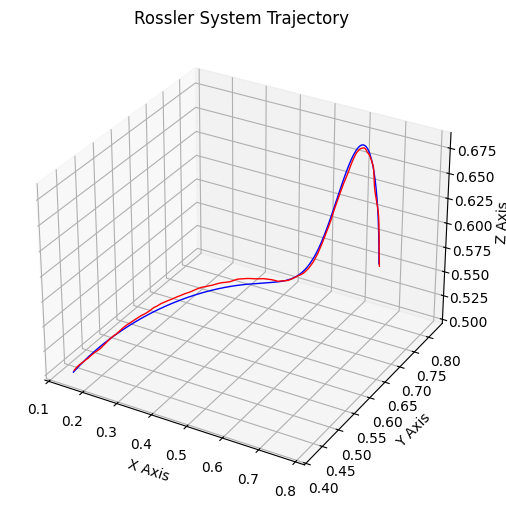

In [41]:
#Autoencoder output and actual outpuut comparison

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Select a sample trajectory from the training data
actual_trajectory = test_data[:batch_size]
obtained_trajectory = res[0]
# Extract x, y, z components
x, y, z = actual_trajectory[:, 0], actual_trajectory[:, 1], actual_trajectory[:, 2]
x1, y1, z1 = obtained_trajectory[:, 0], obtained_trajectory[:, 1], obtained_trajectory[:, 2]
# Plot the Lorenz attractor
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=1, color='b')
ax.plot(x1, y1, z1, lw=1, color='r')

ax.set_title("Rossler System Trajectory")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

plt.show()


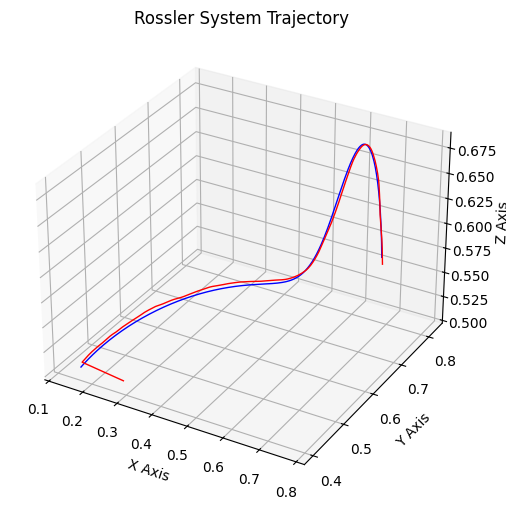

In [42]:
actual_trajectory = test_data[1:batch_size]
obtained_trajectory = res[1]
# Extract x, y, z components
x, y, z = actual_trajectory[:, 0], actual_trajectory[:, 1], actual_trajectory[:, 2]
x1, y1, z1 = obtained_trajectory[:, 0], obtained_trajectory[:, 1], obtained_trajectory[:, 2]
# Plot the Lorenz attractor
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=1, color='b')
ax.plot(x1, y1, z1, lw=1, color='r')

ax.set_title("Rossler System Trajectory")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

plt.show()
